In [1]:
import numpy as np 
from scipy.integrate import odeint
import os, sys, warnings
from pathlib import Path
from os.path import dirname, realpath
script_dir = Path(dirname(realpath('.')))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
import utility as ut
import surrogate_nn as srnn
import matplotlib.pyplot as plt
import pandas as pd
import torch
import sample as sm
from torch import nn
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
warnings.filterwarnings('ignore')

In [16]:
DTYPE = 'float64'
L63_data_path = '../data/L63-trajectories'
save_folder='../data/rf-start-aggresive'
log_interval = 100
milestones = [10*2**n for n in range(15)]
learning_rate = 1e-3
drop = 0.7
steps = int(1e4)
save_interval = 100
N = 20000
L0 = 0.4
L1 = 3.5
beta = 4e-5
partition = [100, 100, 100]
train = np.load(f'{L63_data_path}/train.npy').astype(DTYPE)
test = np.load(f'{L63_data_path}/test.npy')[:, :, :1000].astype(DTYPE)

model = srnn.SurrogateModel_NN(3, 300, name='nn', save_folder=save_folder)
model.init_with_rf(L0, L1, beta, train, partition)
model.init_with_rf(L0, L1, beta, train, partition=[300, 0, 0])
tau_f_rmse, tau_f_se, rmse, se = model.compute_tau_f(test[:100], error_threshold=0.05)
tau_f_1 = tau_f_se.mean()
model.learn(train[:, :N], 5000, 1e-4, drop=1., batch_size='GD', log_interval=10, save_interval=10)
tau_f_rmse, tau_f_se, rmse, se = model.compute_tau_f(test[:100], error_threshold=0.05)
tau_f_2 = tau_f_se.mean()

tau_f_1 , tau_f_2, tau_f_1 < tau_f_2
model.count_row_types(L0, L1, train.T)

Time taken by compute_tau_f is 1.4700 seconds
step: 0    loss: 1.697458     time elapsed=0.0341
step: 10    loss: 7052.747557     time elapsed=0.3675
step: 20    loss: 779.201154     time elapsed=0.6847
step: 30    loss: 158.337718     time elapsed=1.0098
step: 40    loss: 290.901711     time elapsed=1.3359
step: 50    loss: 131.977051     time elapsed=1.6599
step: 60    loss: 48.841462     time elapsed=1.9942
step: 70    loss: 18.775204     time elapsed=2.3273
step: 80    loss: 6.413785     time elapsed=2.6455
step: 90    loss: 2.026689     time elapsed=2.9632
step: 100    loss: 1.930176     time elapsed=3.2901
step: 110    loss: 2.018084     time elapsed=3.6144
step: 120    loss: 1.741558     time elapsed=3.9423
step: 130    loss: 1.756824     time elapsed=4.2712
step: 140    loss: 1.728097     time elapsed=4.5982
step: 150    loss: 1.727765     time elapsed=4.9164
step: 160    loss: 1.721237     time elapsed=5.2441
step: 170    loss: 1.719595     time elapsed=5.5727
step: 180    los

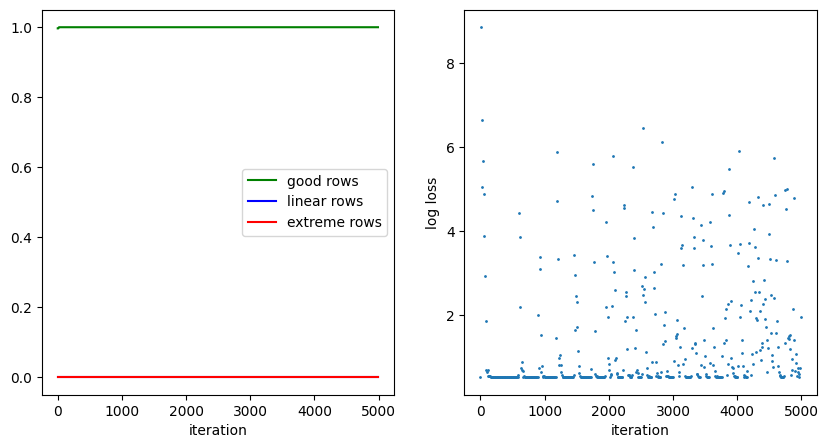

In [17]:
df = pd.read_csv(f'{model.save_folder}/train_log.csv')
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(df['iteration'], df['good_rows_W_in'], c='green', label='good rows')
ax1.plot(df['iteration'], df['linear_rows_W_in'], c='blue', label = 'linear rows')
ax1.plot(df['iteration'], df['extreme_rows_W_in'], c='red', label = 'extreme rows')
ax2.scatter(df['iteration'], np.log(df['loss']), s=1)
ax1.set_xlabel('iteration')
ax2.set_xlabel('iteration')
ax2.set_ylabel('log loss')
ax1.legend()
plt.savefig(f'{model.save_folder}/row_types.png')

In [18]:
tau_f_1, tau_f_2

(5.429424, 1.1316760000000001)

In [20]:
model = srnn.SurrogateModel_NN(3, 300, name='nn', save_folder=save_folder+'-suboptimal')
model.init_with_rf(L0, L1, beta, train, partition)
model.init_with_rf(L0, L1, beta, train, partition=[100, 100, 100])
tau_f_rmse, tau_f_se, rmse, se = model.compute_tau_f(test[:100], error_threshold=0.05)
tau_f_1 = tau_f_se.mean()
model.learn(train[:, :N], 5000, 1e-4, drop=1., batch_size='GD', log_interval=10, save_interval=10)
tau_f_rmse, tau_f_se, rmse, se = model.compute_tau_f(test[:100], error_threshold=0.05)
tau_f_2 = tau_f_se.mean()

tau_f_1 , tau_f_2, tau_f_1 < tau_f_2
model.count_row_types(L0, L1, train.T)

Time taken by compute_tau_f is 1.4507 seconds
step: 0    loss: 4.398474     time elapsed=0.0353
step: 10    loss: 14394.158074     time elapsed=0.3541
step: 20    loss: 340.220156     time elapsed=0.6767
step: 30    loss: 1539.408976     time elapsed=0.9947
step: 40    loss: 503.839748     time elapsed=1.3063
step: 50    loss: 38.421184     time elapsed=1.6236
step: 60    loss: 17.389361     time elapsed=1.9350
step: 70    loss: 9.349411     time elapsed=2.2471
step: 80    loss: 6.966876     time elapsed=2.5595
step: 90    loss: 4.936360     time elapsed=2.8704
step: 100    loss: 4.737706     time elapsed=3.1824
step: 110    loss: 4.880142     time elapsed=3.4956
step: 120    loss: 4.687091     time elapsed=3.8066
step: 130    loss: 4.499545     time elapsed=4.1202
step: 140    loss: 4.491085     time elapsed=4.4337
step: 150    loss: 4.480792     time elapsed=4.7510
step: 160    loss: 4.468451     time elapsed=5.0664
step: 170    loss: 4.464382     time elapsed=5.3798
step: 180    los

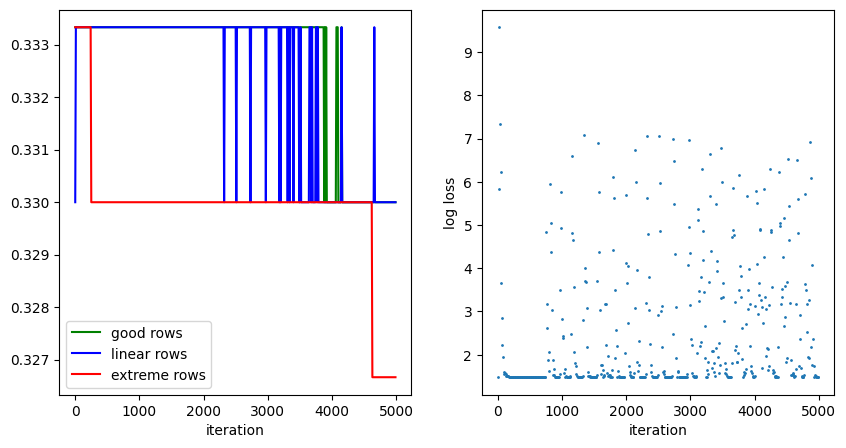

In [21]:
df = pd.read_csv(f'{model.save_folder}/train_log.csv')
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(df['iteration'], df['good_rows_W_in'], c='green', label='good rows')
ax1.plot(df['iteration'], df['linear_rows_W_in'], c='blue', label = 'linear rows')
ax1.plot(df['iteration'], df['extreme_rows_W_in'], c='red', label = 'extreme rows')
ax2.scatter(df['iteration'], np.log(df['loss']), s=1)
ax1.set_xlabel('iteration')
ax2.set_xlabel('iteration')
ax2.set_ylabel('log loss')
ax1.legend()
plt.savefig(f'{model.save_folder}/row_types.png')

In [22]:
tau_f_1, tau_f_2

(4.935112, 4.545814000000001)

In [23]:
save_folder='../data/rf-start-super-aggresive'
model = srnn.SurrogateModel_NN(3, 300, name='nn', save_folder=save_folder+'-suboptimal')
model.init_with_rf(L0, L1, beta, train, partition)
model.init_with_rf(L0, L1, beta, train, partition=[100, 100, 100])
tau_f_rmse, tau_f_se, rmse, se = model.compute_tau_f(test[:100], error_threshold=0.05)
tau_f_1 = tau_f_se.mean()
model.learn(train[:, :N], 5000, 1e-3, drop=1., batch_size='GD', log_interval=10, save_interval=10)
tau_f_rmse, tau_f_se, rmse, se = model.compute_tau_f(test[:100], error_threshold=0.05)
tau_f_2 = tau_f_se.mean()

tau_f_1 , tau_f_2, tau_f_1 < tau_f_2
model.count_row_types(L0, L1, train.T)

Time taken by compute_tau_f is 1.4617 seconds
step: 0    loss: 10.448396     time elapsed=0.0368
step: 10    loss: 2036355.945938     time elapsed=0.3456
step: 20    loss: 451546.797533     time elapsed=0.6554
step: 30    loss: 272725.187123     time elapsed=0.9640
step: 40    loss: 34441.853250     time elapsed=1.2764
step: 50    loss: 46325.891777     time elapsed=1.5909
step: 60    loss: 12442.013503     time elapsed=1.9149
step: 70    loss: 2330.878823     time elapsed=2.2278
step: 80    loss: 461.224103     time elapsed=2.5388
step: 90    loss: 128.493332     time elapsed=2.8486
step: 100    loss: 89.677285     time elapsed=3.1568
step: 110    loss: 83.310148     time elapsed=3.4658
step: 120    loss: 84.480322     time elapsed=3.7744
step: 130    loss: 81.365416     time elapsed=4.0833
step: 140    loss: 72.344507     time elapsed=4.3908
step: 150    loss: 64.688316     time elapsed=4.7018
step: 160    loss: 61.297234     time elapsed=5.0288
step: 170    loss: 58.619724     time 

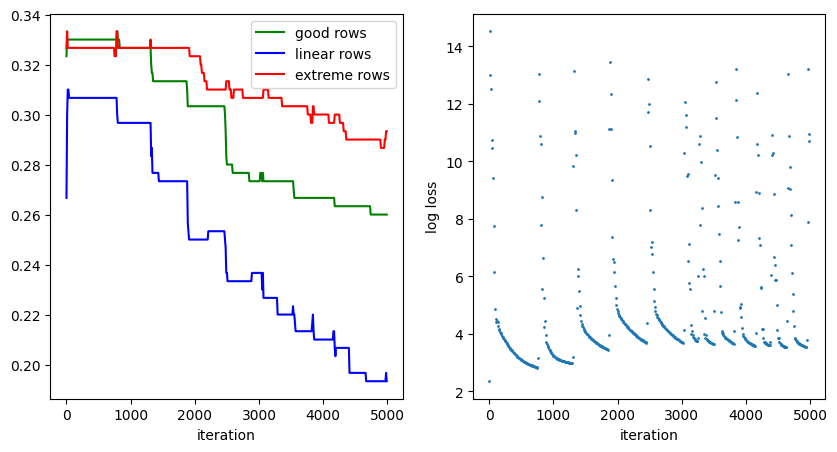

In [24]:
df = pd.read_csv(f'{model.save_folder}/train_log.csv')
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(df['iteration'], df['good_rows_W_in'], c='green', label='good rows')
ax1.plot(df['iteration'], df['linear_rows_W_in'], c='blue', label = 'linear rows')
ax1.plot(df['iteration'], df['extreme_rows_W_in'], c='red', label = 'extreme rows')
ax2.scatter(df['iteration'], np.log(df['loss']), s=1)
ax1.set_xlabel('iteration')
ax2.set_xlabel('iteration')
ax2.set_ylabel('log loss')
ax1.legend()
plt.savefig(f'{model.save_folder}/row_types.png')

In [25]:
tau_f_1,  tau_f_2

(3.6582, 0.17326400000000006)

In [26]:
save_folder='../data/rf-start-super-aggresive'
model = srnn.SurrogateModel_NN(3, 300, name='nn', save_folder=save_folder)
model.init_with_rf(L0, L1, beta, train, partition)
model.init_with_rf(L0, L1, beta, train, partition=[300, 0, 0])
tau_f_rmse, tau_f_se, rmse, se = model.compute_tau_f(test[:100], error_threshold=0.05)
tau_f_1 = tau_f_se.mean()
model.learn(train[:, :N], 5000, 1e-3, drop=1., batch_size='GD', log_interval=10, save_interval=10)
tau_f_rmse, tau_f_se, rmse, se = model.compute_tau_f(test[:100], error_threshold=0.05)
tau_f_2 = tau_f_se.mean()

tau_f_1 , tau_f_2, tau_f_1 < tau_f_2
model.count_row_types(L0, L1, train.T)

Time taken by compute_tau_f is 1.4598 seconds
step: 0    loss: 1.901932     time elapsed=0.0317
step: 10    loss: 725100.942994     time elapsed=0.3527
step: 20    loss: 10022.363923     time elapsed=0.6682
step: 30    loss: 87801.309958     time elapsed=0.9802
step: 40    loss: 18266.801234     time elapsed=1.2987
step: 50    loss: 1049.772522     time elapsed=1.6123
step: 60    loss: 2164.933311     time elapsed=1.9288
step: 70    loss: 1477.131799     time elapsed=2.2441
step: 80    loss: 605.171372     time elapsed=2.5602
step: 90    loss: 230.716030     time elapsed=2.8741
step: 100    loss: 90.289905     time elapsed=3.1920
step: 110    loss: 45.566278     time elapsed=3.5069
step: 120    loss: 38.278082     time elapsed=3.8216
step: 130    loss: 37.453244     time elapsed=4.1346
step: 140    loss: 33.467291     time elapsed=4.4508
step: 150    loss: 30.095304     time elapsed=4.7659
step: 160    loss: 28.181511     time elapsed=5.0799
step: 170    loss: 26.178419     time elapse

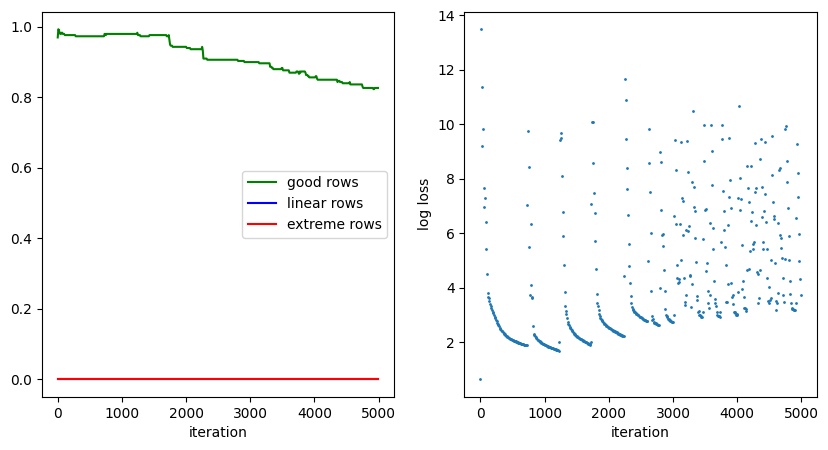

In [27]:
df = pd.read_csv(f'{model.save_folder}/train_log.csv')
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(df['iteration'], df['good_rows_W_in'], c='green', label='good rows')
ax1.plot(df['iteration'], df['linear_rows_W_in'], c='blue', label = 'linear rows')
ax1.plot(df['iteration'], df['extreme_rows_W_in'], c='red', label = 'extreme rows')
ax2.scatter(df['iteration'], np.log(df['loss']), s=1)
ax1.set_xlabel('iteration')
ax2.set_xlabel('iteration')
ax2.set_ylabel('log loss')
ax1.legend()
plt.savefig(f'{model.save_folder}/row_types.png')

In [28]:
tau_f_1, tau_f_2

(5.278727999999998, 1.9004439999999996)

In [32]:
save_folder='../data/rf-start-none'
model = srnn.SurrogateModel_NN(3, 300, name='nn', save_folder=save_folder)
# model.init_with_rf(L0, L1, beta, train, partition)
# model.init_with_rf(L0, L1, beta, train, partition=[300, 0, 0])
tau_f_rmse, tau_f_se, rmse, se = model.compute_tau_f(test[:100], error_threshold=0.05)
tau_f_1 = tau_f_se.mean()
model.learn(train[:, :N], 20000, 1e-3, drop=1., batch_size='GD', log_interval=10, save_interval=10)
tau_f_rmse, tau_f_se, rmse, se = model.compute_tau_f(test[:100], error_threshold=0.05)
tau_f_2 = tau_f_se.mean()

tau_f_1 , tau_f_2, tau_f_1 < tau_f_2
model.count_row_types(L0, L1, train.T)

Time taken by compute_tau_f is 1.3707 seconds
step: 0    loss: 15589321.487880     time elapsed=0.0323
step: 10    loss: 12825121.138937     time elapsed=0.3543
step: 20    loss: 10426797.782639     time elapsed=0.6738
step: 30    loss: 8399236.830626     time elapsed=0.9950
step: 40    loss: 6723195.670158     time elapsed=1.3124
step: 50    loss: 5368021.723631     time elapsed=1.6329
step: 60    loss: 4303902.062238     time elapsed=1.9524
step: 70    loss: 3497273.753057     time elapsed=2.2713
step: 80    loss: 2906006.814312     time elapsed=2.5904
step: 90    loss: 2479790.234972     time elapsed=2.9204
step: 100    loss: 2181327.592312     time elapsed=3.2380
step: 110    loss: 1978572.430311     time elapsed=3.5599
step: 120    loss: 1841228.962555     time elapsed=3.8781
step: 130    loss: 1745745.098068     time elapsed=4.1955
step: 140    loss: 1674982.125906     time elapsed=4.5143
step: 150    loss: 1616892.889511     time elapsed=4.8360
step: 160    loss: 1562977.268408 

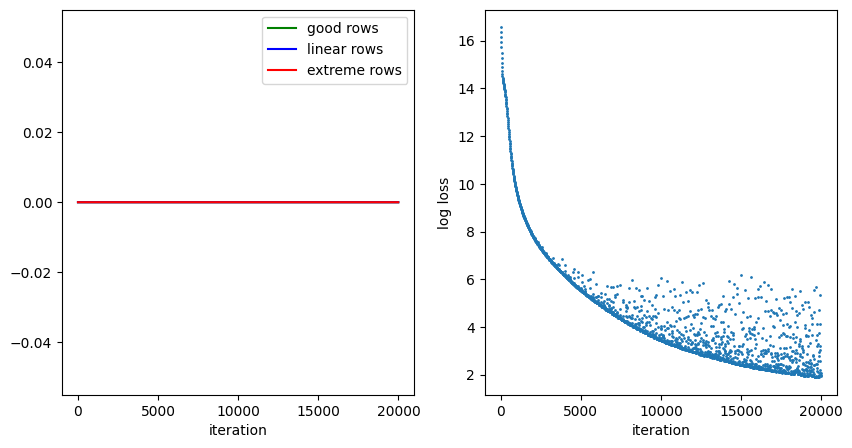

In [33]:
df = pd.read_csv(f'{model.save_folder}/train_log.csv')
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(df['iteration'], df['good_rows_W_in'], c='green', label='good rows')
ax1.plot(df['iteration'], df['linear_rows_W_in'], c='blue', label = 'linear rows')
ax1.plot(df['iteration'], df['extreme_rows_W_in'], c='red', label = 'extreme rows')
ax2.scatter(df['iteration'], np.log(df['loss']), s=1)
ax1.set_xlabel('iteration')
ax2.set_xlabel('iteration')
ax2.set_ylabel('log loss')
ax1.legend()
plt.savefig(f'{model.save_folder}/row_types.png')

In [34]:
tau_f_1, tau_f_2

(0.0, 0.885248)